<a href="https://colab.research.google.com/github/sadrireza/Neural-Networks/blob/main/Combination_of_data_augmentation_and_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision (Men-Women Detection)
##Using Transfer learning and data augmentation

In [1]:
#using os to count no. of files in each folder
import os

#to organize dataset directories
import shutil
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

## 1. Dataset Preparation

### 1.1 Download Dataset from Koggle

In [2]:
'''since we need to upload kaggle.json file to be able to use kaggle datasets,
we use this method to upload a file from our system.
 the _ is used for temporary variables in python
 and we use it not to show the content of file here for security reasons'''
from google.colab import files
_ = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
#A linux code to transfer the file because colab base is linux
!mkdir ~/.kaggle #make the directory in linux
!cp kaggle.json ~/.kaggle #copy in linux
!chmod 600 ~/.kaggle/kaggle.json #for security reasons,restricting access to file to the owner

#in windows we have to save kaggle.jason in this path:
#C:\Users\username\.kaggle
#We have to download kaggle.json from our personal area in kaggle website
#in the API section

In [4]:
#downloading dataset from kaggle website (!kaggle datasets download -d username/dataset name)
!kaggle datasets download -d saadpd/menwomen-classification

Dataset URL: https://www.kaggle.com/datasets/saadpd/menwomen-classification
License(s): copyright-authors
100% 803M/806M [00:28<00:00, 32.0MB/s]
100% 806M/806M [00:29<00:00, 29.1MB/s]


In [5]:
#unzipping dataset(-qq for not showing extracted files)
!unzip -qq menwomen-classification.zip

### 1.2 Dataset Evaluation

In [6]:
#to correct numerous places at the same time, use Alt
num_men_train = len(os.listdir('traindata/traindata/men'))
num_women_train = len(os.listdir('traindata/traindata/women'))
num_men_test = len(os.listdir('testdata/testdata/men'))
num_women_test = len(os.listdir('testdata/testdata/women'))

print (f'Train: Men: {num_men_train} & Women: {num_women_train}')
print (f'Test: Men: {num_men_test} & Women: {num_women_test}')

Train: Men: 1000 & Women: 1912
Test: Men: 418 & Women: 915


###1.3 Prepare Data Directories

In [7]:
'''
Dataset is not suitable rightnow
Dataset should be such that each folder contains only images of one class only
we can do this either with coding or manually in our system
'''

new_base_dir = pathlib.Path('men_vs_women_small') #the base directory is made

'''make_subset gets two indexes to know from which image begins
 and to which one ends in each folder'''

def make_subset(base_dir, subset_name, start_index, end_index):
    for category in ('men', 'women'):
        dir = new_base_dir / subset_name / category
        if not os.path.exists(dir):
          os.makedirs(dir) #All above folders and subfolder are made

        '''
        above we want to make a directory. the address of directory
        is like what is equal to dir. so the main directory is called new_base_dir
        and the subfolder is a name which we give in later (subset_name)
        and then we have two categories men and women
        '''

        #getting all files from the source directory by listdir
        files = os.listdir(os.path.join(base_dir, category))

        #getting names of those images we want from start index to end index
        fnames = [files[i] for i in range(start_index, end_index)]

        #copying those images to the destination directory
        for fname in fnames:
          shutil.copyfile(src=os.path.join(base_dir, category, fname),
                      dst=os.path.join(dir,fname))

          '''
To turn image files into batches of preprocessed tensors in general,
Keras features the utility function:
image_dataset_from_directory()
1-list the subdirectories of directory
2-assume each one contains one class
3-index the image files in each subd.
4-create and return a tf.data.Dataset object
this object configured to read files,
shuffle them, decode them to tensors, resize them to
a shared size,pack them into batches
'''

In [8]:
#now we use make_subset
make_subset('traindata/traindata', 'validation', start_index=0, end_index=200)
make_subset('traindata/traindata', 'train', start_index=200, end_index=999)
make_subset('testdata/testdata', 'test', start_index=0, end_index=400)

###1.4 Load Dataset

In [9]:
print ('Train loader:') #to determine which report is shown
train_dataset = image_dataset_from_directory(
    'men_vs_women_small/train',
    image_size = (180,180),
    batch_size=32,
    label_mode = 'binary' #because we have only two classes
)
print ('Validation loader:') #to determine which report is shown
validation_dataset = image_dataset_from_directory(
    'men_vs_women_small/validation',
    image_size = (180,180),
    batch_size=32,
    label_mode = 'binary' #because we have only two classes
)

print ('Test loader:') #to determine which report is shown
test_dataset = image_dataset_from_directory(
    'men_vs_women_small/test',
    image_size = (180,180),
    batch_size=32,
    label_mode = 'binary' #because we have only two classes
)

Train loader:
Found 1598 files belonging to 2 classes.
Validation loader:
Found 400 files belonging to 2 classes.
Test loader:
Found 800 files belonging to 2 classes.


data batch shape: (32, 180, 180, 3)
label batch shape: (32, 1)


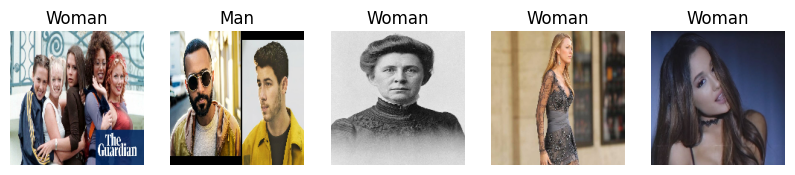

In [12]:
#showing 5 samples
for data_batch, label_batch in train_dataset:
  print('data batch shape:', data_batch.shape)
  print('label batch shape:', label_batch.shape)

  #Show five random examples of the loaded batch
  fig, axes = plt.subplots(1, 5, figsize = (10,3))
  for i, ax in enumerate(axes):
    ax.imshow(data_batch[i].numpy().astype('uint8'))
    ax.set_axis_off()
    ax.set_title('Man' if label_batch[i].numpy()==0 else 'Woman')
  break
plt.show()

##2.Model Design (Step 1)

In [15]:
#Loading our pre_trained model
conv_base = keras.applications.vgg16.VGG16(
    weights='imagenet', #bring in imagenet weights
    include_top=False, #no need to last dense layer
    input_shape=(180,180,3))

In [16]:
#Here we freeze base model's parameters because we only want to train augmented model's parameters
#so here after loading base model (pre-trained model) we freeze their trainability
conv_base.trainable = False

In [13]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [21]:
#since we froze the base model parameters, now trainable parameters will be less than all parameter
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers. Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 180, 180, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 180, 180, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_3 (GetItem)      │ (None, 180, 180)       │              0 │ sequential[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_4 (GetItem)      │ (None, 180, 180)       │              0 │ sequential[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_5 (GetItem)      │ (None, 180, 180)       │              0 │ sequential[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_1 (Stack)           │ (None, 180, 180, 3)    │              0 │ get_item_3[0][0],      │
│                           │                        │                │ get_item_4[0][0],      │
│                           │                        │                │ get_item_5[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 180, 180, 3)    │              0 │ stack_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 5, 5, 512)      │     14,714,688 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 512)            │              0 │ vgg16[1][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │        131,328 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │            257 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

##3.Train (Step 1)

In [22]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [23]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='covnet_from_scratch.keras',
        save_best_only=True,
        monitor='val_loss'
        )
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 366ms/step - accuracy: 0.6070 - loss: 4.0568 - val_accuracy: 0.7700 - val_loss: 2.3549
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 282ms/step - accuracy: 0.7471 - loss: 1.7173 - val_accuracy: 0.8425 - val_loss: 1.1107
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 285ms/step - accuracy: 0.7910 - loss: 1.4427 - val_accuracy: 0.8400 - val_loss: 1.2396
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 286ms/step - accuracy: 0.8238 - loss: 1.0523 - val_accuracy: 0.8375 - val_loss: 0.9586
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 275ms/step - accuracy: 0.8082 - loss: 1.0997 - val_accuracy: 0.8075 - val_loss: 1.4432
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 286ms/step - accuracy: 0.7896 - loss: 1.2879 - val_accuracy: 0.8500 - val_loss: 0.9354
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 299ms/step - accuracy: 0.8135 - loss: 1.1354 - val_accuracy: 0.8500 - val_loss: 0.8665
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 281ms/step - accuracy: 0.8092 - loss: 0.8264 - val_accu

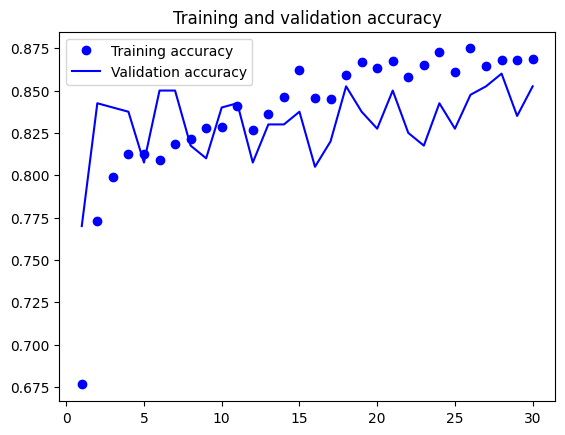

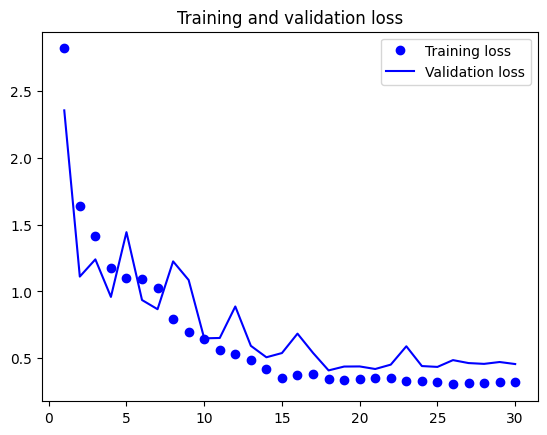

In [24]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#As we see here, the overfitting is less than the case which we did not have augmentation

In [25]:
import os
print(os.listdir("."))

['.config', 'kaggle.json', 'testdata', 'menwomen-classification.zip', 'covnet_from_scratch.keras', 'traindata', 'men_vs_women_small', 'sample_data']


In [27]:
test_model = keras.models.load_model("/content/covnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step - accuracy: 0.8687 - loss: 0.3800
Test accuracy: 0.881


## 4.Model Design (Step 2)

In [32]:
'''
We can go further
we can also unfreeze the latest convolution layer
and make it trainable
and train the model again
so this time the latest conv layer and classification layers are
trained together
It is called fine tuning
the important thing here is that if we want to go further,
(train the latest conv layer) we have to train the classifier before that
this is the reason why we first trained classifier and
froze all the model, then we train classifier+last conv
and freeze the model
Another important point is thatr if we have batch normalization
layer, we can not unfreeze layers.(in vgg we do not have)
'''

conv_base.trainable = True
for layer in conv_base.layers[:-4]: #4last layers(conv) become true (unfrozen)
  layer.trainable = False

'''
models in keras are mutable. we just changed a layer
but our model has changed. if we take a summary here, we see that no. of
parameters changed from 131k to 7m. so we can build a model,
train it and then change a layer only, it result in
changing the whole model.
we do not build a new model. the same model just changes.
'''

##5. Train (Step 2)

In [33]:
#we should not run the model again. we should just run compile to change parameters
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=['accuracy'])

In [34]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='fine_tuning.keras',
        save_best_only=True,
        monitor='val_loss'
        )
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 324ms/step - accuracy: 0.9616 - loss: 0.0967 - val_accuracy: 0.8675 - val_loss: 0.5068
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 285ms/step - accuracy: 0.9677 - loss: 0.0690 - val_accuracy: 0.8650 - val_loss: 0.5364
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 291ms/step - accuracy: 0.9674 - loss: 0.0882 - val_accuracy: 0.8700 - val_loss: 0.4938
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 288ms/step - accuracy: 0.9798 - loss: 0.0560 - val_accuracy: 0.8600 - val_loss: 0.5652
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 288ms/step - accuracy: 0.9687 - loss: 0.0770 - val_accuracy: 0.8800 - val_loss: 0.4884
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 301ms/step - accuracy: 0.9859 - loss: 0.0508 - val_accuracy: 0.8825 - val_loss: 0.4702
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 284ms/step - accuracy: 0.9770 - loss: 0.0683 - val_accuracy: 0.8925 - val_loss: 0.5339
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 285ms/step - accuracy: 0.9778 - loss: 0.0614 - val_accu

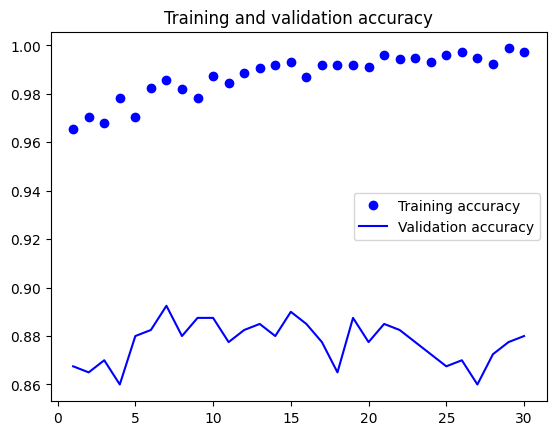

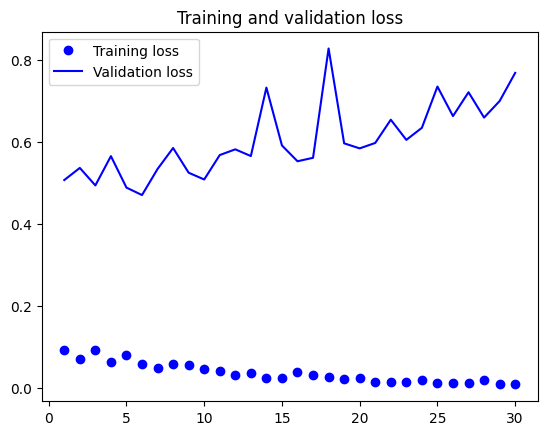

In [36]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [35]:
test_model = keras.models.load_model("/content/fine_tuning.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9331 - loss: 0.3252
Test accuracy: 0.935


#### we can see overfitting but we reached our goal. with almost few images, we trained a large model, we used transfer learning and data augmentation and some other techniques for image classification.

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
!cp 'fine_tuning.keras' '/content/drive/MyDrive/'